In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from math import sin, cos, asin, sqrt, radians, pi
from scipy.optimize import curve_fit, fsolve
import random
from tabulate import tabulate

matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams.update({'font.size': 20})

In [2]:
#File names
crater=['crater'+f'{i:03}'+'_hpar' for i in range(1,106)]
crater_lon=['crater'+f'{i:03}'+'_hpar'+'.lon' for i in range(1,106)]
crater_lat=['crater'+f'{i:03}'+'_hpar'+'.lat' for i in range(1,106)]
files='/Users/iswi5283/Desktop/research/Craters/'
cfiles='/Users/iswi5283/Desktop/research/Craters/data/hpar/'
sfiles='/Users/iswi5283/Desktop/research/Craters/data/hpar_og/'
rfiles='/Users/iswi5283/Desktop/research/Craters/data/ra/'

centers = pd.read_csv(files+'MoonCraters.csv')
cNames = centers['Names '].values
cNumber = centers['Crater No.'].values
cLon = centers['Lon (°) '].values
cLat = centers['Lat (°) '].values
cD = centers['D (km)'].values #km
cR = cD / 2 #km
ages_maz = centers['Age (Myr)'].values #Myr

In [3]:
def gCD(lon1, lat1, lon2, lat2, R=1737.4):
    
    """Haversine Formula: 
    Calculating distances between two points given their longitudes and latitudes
    R_moon=1737.4 km"""
    
    lon1_rad = radians(lon1) #convert to radians
    lat1_rad = radians(lat1)
    lon2_rad = radians(lon2)
    lat2_rad = radians(lat2)
    
    dlon2 = (lon2_rad - lon1_rad) / 2 # difference in longitude
    dlat2 = (lat2_rad - lat1_rad) / 2 # difference in latitude
    
    sin2_dlon2 = (sin(dlon2))**2 # sin squared of difference in longitude
    sin2_dlat2 = (sin(dlat2))**2 # sin squared of difference in latitude
    
    d = 2 * R * asin ( sqrt( sin2_dlat2 + cos(lat1_rad) * cos(lat2_rad) * sin2_dlon2 ) )
    
    return d

In [4]:
#Load each individual crater's H-parameter DIVINER data
hpar=[np.genfromtxt(sfiles+crater[i])*(np.genfromtxt(sfiles+crater[i])!=-32768) for i in range(105)]
#Load each individual crater's longitude and latitude grids
lon_hpar=[np.genfromtxt(sfiles+crater_lon[i]) for i in range(105)]
lat_hpar=[np.genfromtxt(sfiles+crater_lat[i]) for i in range(105)]

In [5]:
#Shape of each crater file
hpar_m = [hpar[i].shape[0] for i in range(105)]
hpar_n = [hpar[i].shape[1] for i in range(105)]

In [6]:
#Create grid in terms of distance from the crater centers (in km)
distances_hpar=[np.array([[gCD(cLon[i],cLat[i],lon_hpar[i][j,k],lat_hpar[i][j,k]) for k in range(hpar_n[i])] for j in range(hpar_m[i])]) for i in range(105)]
#Distance grid in terms of crater radii from the crater centers
distances_hpar_cr=[np.array((distances_hpar[i]/cR[i])-1) for i in range(105)]

In [7]:
#Define the regions of interest surrounding the craters
#Model 1: from -0.1 to 0.8 crater radii
#Model 2: from -0.2 to 0.8 crater radii
cond_hpar_1=[np.array([[(dist>=-0.1)&(dist<=0.8) for dist in row] for row in distances_hpar_cr[i]]) for i in range(105)]
cond_hpar_2=[np.array([[(dist>=-0.2)&(dist<=0.8) for dist in row] for row in distances_hpar_cr[i]]) for i in range(105)]

In [8]:
#All H-parameter values within the regions of Model 1 and 2
h_par_values_1=[]
h_par_values_err_1=[]
h_par_values_2=[]
h_par_values_err_2=[]
for i in range(105):
    h_1=[]
    h_2=[]
    for j in np.arange(0,hpar_m[i]):
        for k in np.arange(0,hpar_n[i]):
            if (cond_hpar_1[i][j,k]==True)&(hpar[i][j,k]>0):
                h_1.append(hpar[i][j,k])
            if (cond_hpar_2[i][j,k]==True)&(hpar[i][j,k]>0):
                h_2.append(hpar[i][j,k])
    h_par_values_1.append(h_1)
    h_par_values_err_1.append(np.std(h_1))
    h_par_values_2.append(h_2)
    h_par_values_err_2.append(np.std(h_2))

In [9]:
#Final H-parameter values assigned to each crater
#Model 1: 10th percentile
#Model 2: 15th percentile
h_par_1=np.array([np.percentile(h_par_values_1[i],10) for i in range(105)])
h_par_err_1=np.array([np.std(hpar[i],where=cond_hpar_1[i])/np.sqrt(len(cond_hpar_1[i])/cR[i]) for i in range(105)])

h_par_2=np.array([np.percentile(h_par_values_2[i],15) for i in range(105)])
h_par_err_2=np.array([np.std(hpar[i],where=cond_hpar_2[i])/np.sqrt(len(cond_hpar_2[i])/cR[i]) for i in range(105)])

In [10]:
def func_age(x, A, B, C, tau):
    """H-parameter function given age (x)"""
    return A*np.exp(-x/tau)+B*(1-np.exp(-x/tau))+C*np.log10(x)

In [11]:
#Define parameters of the model fit between H-parameter and ages
new_popt_1,new_pcov_1=curve_fit(func_age,ages_maz,h_par_1,sigma=h_par_err_1,p0=(0.015,0.06,0.02,350),bounds=(0.001,np.inf))
new_popt_2,new_pcov_2=curve_fit(func_age,ages_maz,h_par_2,sigma=h_par_err_2,p0=(0.032,0.05,0.02,150),bounds=(0.001,np.inf))

new_err_1=np.sqrt(np.diag(new_pcov_1))
new_err_2=np.sqrt(np.diag(new_pcov_2))

(nA1,nB1,nC1,ntau1)=new_popt_1
(nA1_err,nB1_err,nC1_err,ntau1_err)=new_err_1
(nA2,nB2,nC2,ntau2)=new_popt_2
(nA2_err,nB2_err,nC2_err,ntau2_err)=new_err_2

In [12]:
def equation1(x,H):
    '''Equation used to calculate ages from Model 1 of the H-parameter age estimates'''
    return nA1*np.exp(-x/ntau1)+nB1*(1-np.exp(-x/ntau1))+nC1*np.log10(x)-H

def equation2(x,H):
    '''Equation used to calculate ages from Model 2 of the H-parameter age estimates'''
    return nA2*np.exp(-x/ntau2)+nB2*(1-np.exp(-x/ntau2))+nC2*np.log10(x)-H

def age_error1(x, H, H_error):
    '''Errors for the calculate ages from Model 1 of the H-parameter age estimates'''
    df_dA = np.exp(-x/ntau1)
    df_dB = 1 - np.exp(-x/ntau1)
    df_dC = np.log(x)
    df_dtau = (nA1*x*np.exp(-x/ntau1) - nB1*x*np.exp(-x/ntau1) + nC1*x**2) / ntau1**2
    t_error = np.sqrt((H_error**2 + (nA1_err * df_dA)**2 + (nB1_err * df_dB)**2 + (nC1_err * df_dC)**2 + (ntau1_err * df_dtau)**2))
    return t_error

def age_error2(x, H, H_error):
    '''Errors for the calculate ages from Model 2 of the H-parameter age estimates'''
    df_dA = np.exp(-x/ntau2)
    df_dB = 1 - np.exp(-x/ntau2)
    df_dC = np.log(x)
    df_dtau = (nA2*x*np.exp(-x/ntau2) - nB2*x*np.exp(-x/ntau2) + nC2*x**2) / ntau2**2
    t_error = np.sqrt((H_error**2 + (nA2_err * df_dA)**2 + (nB2_err * df_dB)**2 + (nC2_err * df_dC)**2 + (ntau2_err * df_dtau)**2))
    return t_error

t_values_1 = np.zeros(105)
t_values_2 = np.zeros(105)
t_values_1_err = np.zeros(105)
t_values_2_err = np.zeros(105)

table_ages=[]

#Calculating ages based on H-parameter values for each crater
for i in range(105):
    #Ages from 4-1350 Myr (youngest and oldest ages in Mazroeui Ages) 
    initial_guesses = [ages_maz[i],4,100,200,300,400,500,600,700,800,900,1000,1350]
    found_solution = False

    for guess in initial_guesses:
        try:
            t_solution1 = fsolve(equation1, x0=guess, args=h_par_1[i])
            age_error_1 = age_error1(t_solution1[0], h_par_1[i],h_par_err_1[i])
            t_solution2 = fsolve(equation2, x0=guess, args=h_par_2[i])
            age_error_2 = age_error2(t_solution2[0], h_par_2[i],h_par_err_1[i])
            
            #If the ages are exactly the guess or Mazroeui Ages, the crater age is either much 
            #higher or lower than the inital guess
            if (t_solution1[0] != (ages_maz[i] or guess))&(t_solution2[0] != (ages_maz[i] or guess)):
                #Scale the error if needed. Some age uncertainities are too small
                if (h_par_1[i]/h_par_err_1[i])>= (t_solution1[0]/age_error_1):
                    t_values_1[i]=t_solution1[0]
                    t_values_2[i]=t_solution2[0]
                    t_values_1_err[i]=age_error_1
                    t_values_2_err[i]=age_error_2
                    found_solution = True
                    break  
                else:
                    age_error_scale=(t_solution1[0]/age_error_1)/(h_par_1[i]/h_par_err_1[i])
                    t_values_1[i]=t_solution1[0]
                    t_values_2[i]=t_solution2[0]
                    t_values_1_err[i]=age_error_1*age_error_scale
                    t_values_2_err[i]=age_error_2*age_error_scale
                    found_solution = True
                    break
        except Exception:
            pass
        
    if not found_solution:
        print(f"Could not find a solution for {cNames[i]}")

/var/folders/lq/x5h8nj3j0tv1vb0dfg7387f800_w_3/T/ipykernel_99246/2703617606.py:3: RuntimeWarning: invalid value encountered in log10
  return nA1*np.exp(-x/ntau1)+nB1*(1-np.exp(-x/ntau1))+nC1*np.log10(x)-H
/Users/iswi5283/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/var/folders/lq/x5h8nj3j0tv1vb0dfg7387f800_w_3/T/ipykernel_99246/2703617606.py:7: RuntimeWarning: invalid value encountered in log10
  return nA2*np.exp(-x/ntau2)+nB2*(1-np.exp(-x/ntau2))+nC2*np.log10(x)-H


Text(1, 0.08, 'B)')

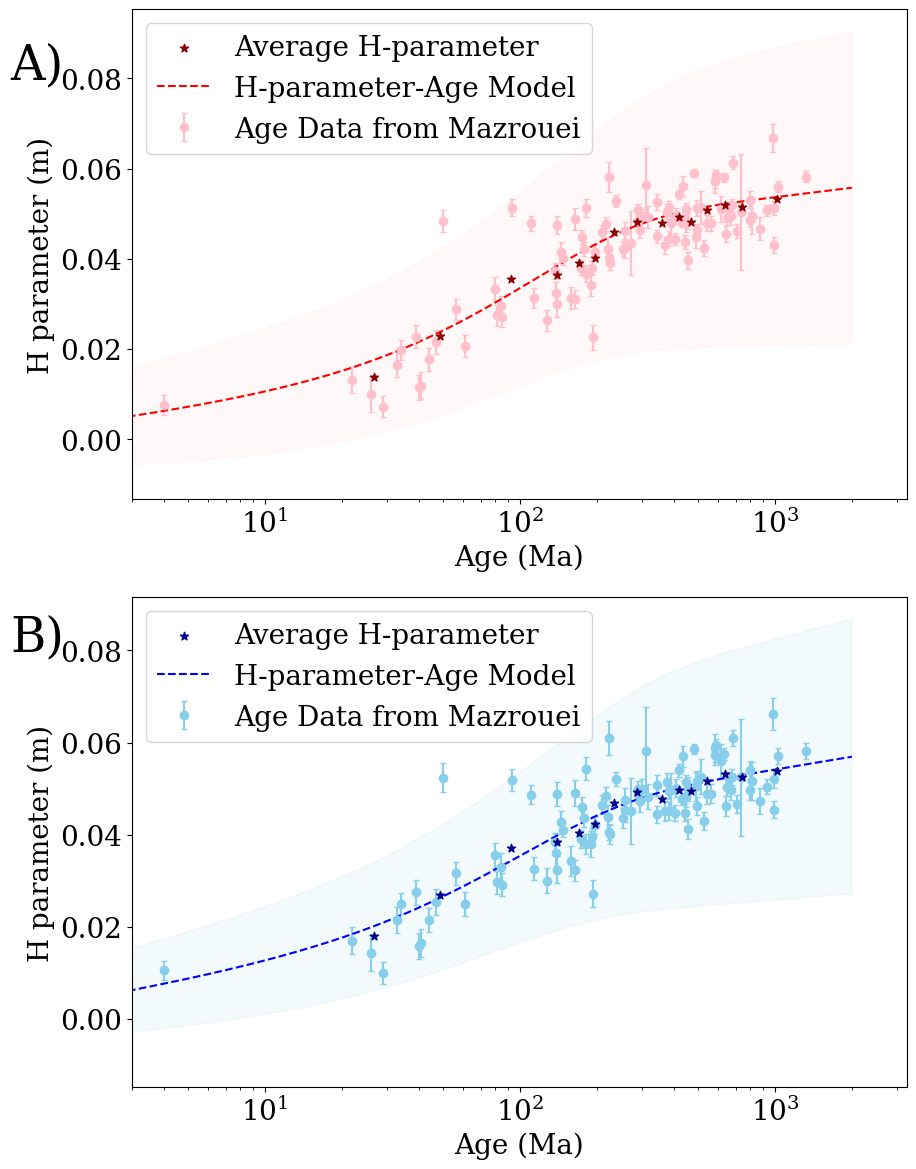

In [13]:
#Figure of H-parameter vs Age using Model 1 and Model 2

new_time=np.arange(0.1,2000,0.1)
#Creating curves for Model 1
h_1_new=func_age(new_time,nA1,nB1,nC1,ntau1)
h_1_pos_err=func_age(new_time,nA1+nA1_err,nB1+nB1_err,nC1+nC1_err,ntau1+ntau1_err)
h_1_neg_err=func_age(new_time,nA1-nA1_err,nB1-nB1_err,nC1-nC1_err,ntau1-ntau1_err)
#Creating curves for Model 2
h_2_new=func_age(new_time,nA2,nB2,nC2,ntau2)
h_2_pos_err=func_age(new_time,nA2+nA2_err,nB2+nB2_err,nC2+nC2_err,ntau2+ntau2_err)
h_2_neg_err=func_age(new_time,nA2-nA2_err,nB2-nB2_err,nC2-nC2_err,ntau2-ntau2_err)
#Creating average points on the plot to represent 15 ranges of ages
sort_age=np.sort(ages_maz)
sort_hpar1=np.array(h_par_1)[np.argsort(ages_maz)]
sort_hpar2=np.array(h_par_2)[np.argsort(ages_maz)]

bin_ages1 = np.array([[np.average(sort_age[(i-1)*7:i*7]),np.average(sort_hpar1[(i-1)*7:i*7])] for i in range(1, 16)])
bin_ages2 = np.array([[np.average(sort_age[(i-1)*7:i*7]),np.average(sort_hpar2[(i-1)*7:i*7])] for i in range(1, 16)])

#Figure of H-parameter vs Age
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,14))

ax1.scatter(bin_ages1[:,0],bin_ages1[:,1],color="darkred",label="Average H-parameter",marker="*",zorder=10)
ax1.errorbar(ages_maz, h_par_1, abs(h_par_err_1), fmt='o', capsize=2, color='pink', label='Age Data from Mazrouei')
ax1.plot(new_time, h_1_new, label='H-parameter-Age Model', color='r', linestyle='--')
ax1.fill_between(new_time, h_1_neg_err, h_1_pos_err,alpha=0.1,color='pink')
ax1.legend(loc="upper left")
ax1.set_xlabel('Age (Ma)')
ax1.set_ylabel('H parameter (m)')
ax1.set_xscale("log")
ax1.set_xlim(3)
ax1.text(1,0.08,"A)",size='xx-large')

ax2.scatter(bin_ages2[:,0],bin_ages2[:,1],color="darkblue",label="Average H-parameter",marker="*",zorder=10)
ax2.errorbar(ages_maz, h_par_2, abs(h_par_err_2), fmt='o', capsize=2, color='skyblue', label='Age Data from Mazrouei')
ax2.plot(new_time,h_2_new, label='H-parameter-Age Model', color='b', linestyle='--')
ax2.fill_between(new_time, h_2_neg_err, h_2_pos_err,alpha=0.1,color='skyblue')
ax2.legend(loc="upper left")
ax2.set_xlabel('Age (Ma)')
ax2.set_ylabel('H parameter (m)')
ax2.set_xscale("log")
ax2.set_xlim(3)
ax2.text(1,0.08,"B)",size='xx-large')
#plt.savefig('hpar_age.pdf', format='pdf', dpi=300, transparent=True, bbox_inches='tight');